In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from grl.utils.data import uncompress_episode_rewards

from definitions import ROOT_DIR

In [2]:
results_dir_td = Path(ROOT_DIR, 'results', 'rnn_reruns_td')
results_dir_mc = Path(ROOT_DIR, 'results', 'rnn_reruns_mc')
results_dir_split = Path(ROOT_DIR, 'results', 'rnn_split')

In [31]:

offline_eval = []
# all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())
all_results_paths = list(results_dir_split.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = info['args']
    
    if (args['multihead_loss_mode'] != 'both') and (args['multihead_lambda_coeff'] > 0.):
        continue

    offline_evals = info['episodes_info']['offline_eval']
    eval_freq = args['offline_eval_freq']
    total_steps = args['total_steps']
    
    all_t_undisc_returns = []
    for i, oe in enumerate(offline_evals):
        d = {**args}
        
        avg_undisc_returns = 0
        for ep in oe['episode_rewards']:
            episode_rewards = np.array(uncompress_episode_rewards(ep['episode_length'], ep['most_common_reward'], ep['compressed_rewards']))

            # TODO: calculate value estimation error through q_t - g_t
            undisc_returns = episode_rewards.sum()
            avg_undisc_returns += undisc_returns

        avg_undisc_returns /= len(oe['episode_rewards'])
        d['timestep'] = int(i * eval_freq)
        d['undisc_returns'] = undisc_returns
    
        offline_eval.append(d)

all_res_df = pd.DataFrame(offline_eval)



  0%|          | 0/320 [00:00<?, ?it/s]

In [104]:
arch = "gru"
measure_col = 'undisc_returns'
all_args = list(args.keys())

offline_eval_df = all_res_df[
    (all_res_df['arch'] == arch)
#     & (all_res_df['multihead_lambda_coeff'] >= 0.)
]

unique_seeds = offline_eval_df.seed.unique()

# split_by_args = ['spec', 'multihead_action_mode', 'multihead_loss_mode', 'multihead_lambda_coeff', 'timestep']

# For split exp
split_by_args = ['spec', 'multihead_loss_mode', 'lr']

rnn_grouped = offline_eval_df.groupby(split_by_args, as_index=False)

In [105]:
# take mean and std_err over mean over seeds
rnn_mean = rnn_grouped.mean(numeric_only=True)
rnn_sem = rnn_grouped.sem(numeric_only=True)

# Now we take the max over everything but learning rate
max_over_args = ['lr']
grouped_args = [arg for arg in split_by_args if arg not in max_over_args]
rnn_less_lr_grouped = rnn_mean.groupby(grouped_args, as_index=False)

rnn_arg_maxes = rnn_mean.sort_values(measure_col).drop_duplicates(grouped_args, keep='last')

In [106]:
# drop columns we need in original df
pruned_rnn_arg_maxes = rnn_arg_maxes.drop(columns=['timestep', 'seed'])

# A df of results over all the maxes.
max_offline_eval_df = pruned_rnn_arg_maxes.merge(offline_eval_df, on=split_by_args, how='inner')


In [107]:
max_offline_eval_df.columns

Index(['spec', 'multihead_loss_mode', 'lr', 'no_gamma_terminal_x',
       'max_episode_steps_x', 'epsilon_x', 'hidden_size_x',
       'value_head_layers_x', 'trunc_x', 'residual_obs_val_input_x',
       'multihead_lambda_coeff_x', 'normalize_rewards_x', 'replay_size_x',
       'batch_size_x', 'offline_eval_freq_x', 'offline_eval_episodes_x',
       'offline_eval_epsilon_x', 'checkpoint_freq_x', 'save_all_checkpoints_x',
       'total_steps_x', 'undisc_returns_x', 'no_gamma_terminal_y',
       'max_episode_steps_y', 'algo', 'arch', 'epsilon_y', 'optimizer',
       'hidden_size_y', 'value_head_layers_y', 'trunc_y', 'action_cond',
       'multihead_action_mode', 'residual_obs_val_input_y',
       'multihead_lambda_coeff_y', 'normalize_rewards_y', 'replay_size_y',
       'batch_size_y', 'offline_eval_freq_y', 'offline_eval_episodes_y',
       'offline_eval_epsilon_y', 'checkpoint_freq_y', 'save_all_checkpoints_y',
       'total_steps_y', 'platform', 'seed', 'study_name', 'timestep',
      

In [111]:
df = max_offline_eval_df
pivot_value_key = 'undisc_returns_y'

all_labels = \
    sorted(['_'.join([str(el) for el in row]) for row in df[[arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')]]\
        .drop_duplicates()\
        .to_numpy()])

label_cmap = {}

color = iter(cm.tab10(np.linspace(0, 1, 10)))
for i in range(len(all_labels)):
    c = next(color)
    label_cmap[all_labels[i]] = c

  0%|          | 0/8 [00:00<?, ?it/s]

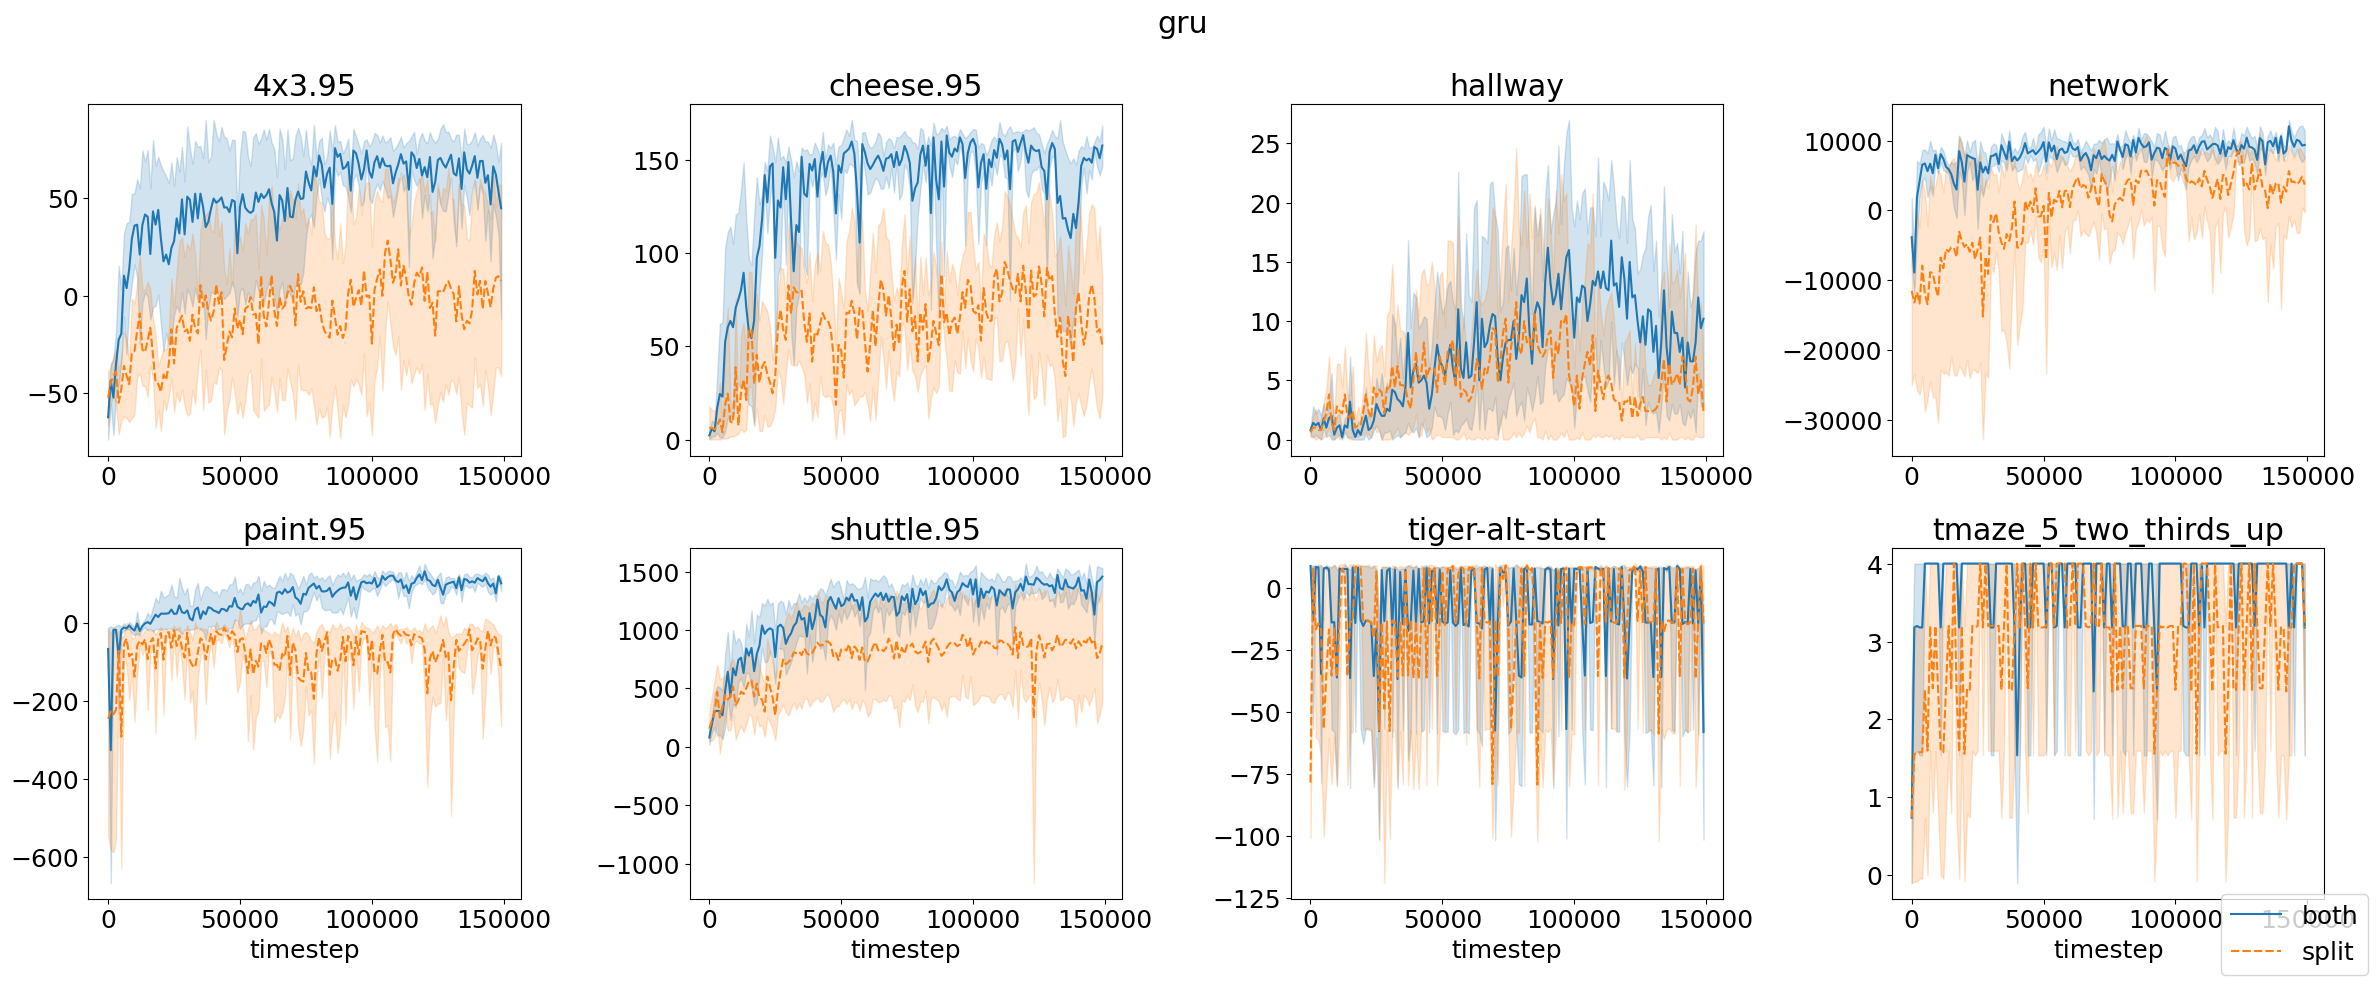

In [115]:
# df = offline_eval_df
# pivot_value_key = 'undisc_returns'

spec_strs = df['spec'].unique()

pivot_cols = [arg for arg in grouped_args if (arg != 'spec') and (arg != 'timestep')] + ['seed']

n_rows, n_cols = 2, np.ceil(len(spec_strs) / 2).astype(int)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))

for i, spec in tqdm(list(enumerate(sorted(spec_strs)))):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    spec_df = df[df['spec'] == spec]
    sorted_spec_df = spec_df.sort_values(by=grouped_args)
    
    # Make a pivot table
    pivot_df = sorted_spec_df.pivot(index='timestep', columns=pivot_cols, values=pivot_value_key)
    
    # Flatten all columns except seed
    col_name = '_'.join([col for col in pivot_cols if col != 'seed'])
    multi_index = pd.MultiIndex.from_tuples([('_'.join([str(c) for c in col[:-1]]), col[-1]) for col in pivot_df.columns], names=[col_name, "seed"])

    pivot_df.columns = multi_index

    sns.lineplot(ax=ax, data=pivot_df, palette=label_cmap)
    
    ax.get_legend().remove()
    ax.set_title(spec)
    if col > 0:
        ax.set_ylabel(None)
    if row < n_rows - 1:
        ax.set_xlabel(None)
        
    handles, labels = ax.get_legend_handles_labels()
    
#     if i >= 1:
#         break
        
fig.legend(handles, labels, loc='lower right')
fig.suptitle(arch)
fig.tight_layout()

In [28]:
fig_path = Path(ROOT_DIR, 'results', f'{arch}_rnn_reruns.pdf')
fig.savefig(fig_path, bbox_inches='tight')

In [113]:
label_cmap

{'both': array([0.1216, 0.4667, 0.7059, 1.    ]),
 'split': array([1.    , 0.498 , 0.0549, 1.    ])}